<h4>Objective:</h4>
To predict the length of stay (LOC) for each patient on case by case basis. This is aimed at helping the hospital have information for optimal resource allocation and better functioning.
<h4>Evauation Metric: </h4>
100 * Accuracy

<h4>Variable Definitions</h4>
0   case_id	==> Case_ID registered in Hospital

1	Hospital_code	==> Unique code for the Hospital

2	Hospital_type_code	==> Unique code for the type of Hospital

3	City_Code_Hospital	==> City Code of the Hospital

4	Hospital_region_code	==> Region Code of the Hospital

5	Available Extra Rooms in Hospital	==> Number of Extra rooms available in the Hospital

6	Department	==> Department overlooking the case

7	Ward_Type	==> Code for the Ward type

8	Ward_Facility_Code	==> Code for the Ward Facility

9	Bed Grade	==> Condition of Bed in the Ward

10	patientid	==> Unique Patient Id

11	City_Code_Patient	==> City Code for the patient

12	Type of Admission	==> Admission Type registered by the Hospital

13	Severity of Illness	==> Severity of the illness recorded at the time o...

14	Visitors with Patient	==> Number of Visitors with the patient

15	Age	==> Age of the patient

16	Admission_Deposit	==> Deposit at the Admission Time

17	Stay	==> Stay Days by the patient

In [1]:
path = "C:/Machine_learning_datafiles/AnalyticsVidya/JanataHack Healthcare Analytics II"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [6]:
os.chdir(path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
import missingno as msno

In [170]:
#modelling packages
import catboost as cat
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, log_loss, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

In [83]:
%matplotlib inline
pd.set_option('display.max_columns', 100)
plt.style.use('bmh')
plt.rcParams['font.size'] = 10

#### Function Utils

In [171]:
def modelMetric(model, xtrain, xval):
    tr_acc = accuracy_score(ytrain, model.predict(xtrain))
    val_acc = accuracy_score(yval, model.predict(xval))
    tr_llos = log_loss(ytrain, model.predict_proba(xtrain))
    val_llos = log_loss(yval, model.predict_proba(xval))
    print(f'Train ACC: {tr_acc.round(5)} Train Logloss : {tr_llos.round(5)}')
    print(f'Val ACC: {val_acc.round(5)} Val Logloss : {val_llos.round(5)}')

In [263]:
def figurePlotting(model, ax=None, title=None):
    if ax:
        plot_confusion_matrix(model, xval, yval, ax=ax)
        ax.set_title(title)
        ax.grid(False)
    else:
        plot_confusion_matrix(model, xval, yval)
        plt.title(title)
    plt.tight_layout(pad=1.)

In [173]:
def TrainModel(model, xtrain, xval):
    if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
        model.fit(xtrain, ytrain, eval_set=[(xval, yval)],
                 early_stopping_rounds=250, verbose=False)
    else:
        model.fit(xtrain, ytrain)
    modelMetric(model, xtrain, xval)
    return model

In [152]:
#importing data
train = pd.read_csv('train.csv')
train_dict= pd.read_csv('train_data_dict.csv')
test= pd.read_csv('test.csv')
subfile = pd.read_csv('sample_submission.csv')

In [8]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [11]:
test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [10]:
train_dict

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [12]:
train.shape, test.shape

((318438, 18), (137057, 17))

In [13]:
train.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276848,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [14]:
test.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,137057.000000,137057.000000,137057.000000,137057.000000,137022.000000,137057.000000,134900.000000,137057.000000,137057.000000
mean,386967.000000,18.343747,4.758692,3.192686,2.634489,65877.903515,7.243996,3.284531,4869.731097
std,39565.092259,8.634694,3.102245,1.164250,0.869295,37942.997623,4.790625,1.777270,1080.766723
min,318439.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,0.000000,1800.000000
25%,352703.000000,11.000000,2.000000,2.000000,2.000000,32945.000000,4.000000,2.000000,4178.000000
50%,386967.000000,19.000000,5.000000,3.000000,3.000000,65786.000000,8.000000,3.000000,4731.000000
75%,421231.000000,26.000000,7.000000,4.000000,3.000000,98851.000000,8.000000,4.000000,5398.000000
max,455495.000000,32.000000,13.000000,21.000000,4.000000,131618.000000,38.000000,32.000000,11920.000000


In [15]:
#Checking for duplicate rows
train.duplicated().shape

(318438,)

There are no duplicated rows

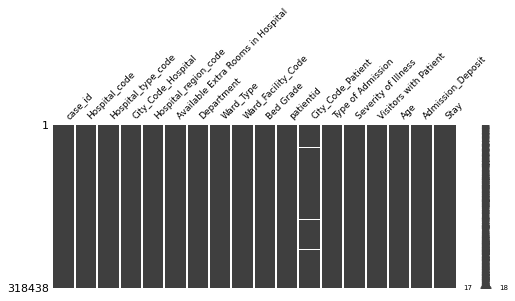

In [155]:
#checking for missing values
missing= msno.matrix(train, figsize=(8,3),fontsize=9)

In [17]:
train.isna().any().sum()

2

There seem to be two coluns with missing values. Let's check them

In [20]:
train.isna().sum()[train.isna().sum() > 0]

Bed Grade             113
City_Code_Patient    4532
dtype: int64

In [24]:
test.isna().sum()[test.isna().sum() > 0]

Bed Grade              35
City_Code_Patient    2157
dtype: int64

In [23]:
train[(train['Bed Grade'].isna()) | (train.City_Code_Patient.isna())].head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
191,192,14,a,1,X,2,radiotherapy,Q,E,3.0,122110,NaN,Emergency,Minor,2,71-80,9096.0,51-60
192,193,30,c,3,Z,2,anesthesia,Q,A,4.0,122110,NaN,Trauma,Minor,2,71-80,5098.0,31-40
193,194,27,a,7,Y,2,radiotherapy,P,C,3.0,122110,NaN,Trauma,Minor,2,71-80,7776.0,21-30
194,195,27,a,7,Y,2,anesthesia,Q,C,3.0,122110,NaN,Trauma,Minor,2,71-80,5988.0,11-20
195,196,25,e,1,X,3,radiotherapy,S,E,3.0,122110,NaN,Urgent,Minor,2,71-80,5333.0,21-30


In [31]:
cat_cols = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Department', 
            'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Type of Admission', 
            'Severity of Illness', 'Age']
num_cols = [col for col in train.columns if col not in cat_cols and col not in ['Stay', 'case_id']]

In [25]:
#Nunique values
train.nunique()

case_id                              318438
Hospital_code                            32
Hospital_type_code                        7
City_Code_Hospital                       11
Hospital_region_code                      3
Available Extra Rooms in Hospital        18
Department                                5
Ward_Type                                 6
Ward_Facility_Code                        6
Bed Grade                                 4
patientid                             92017
City_Code_Patient                        37
Type of Admission                         3
Severity of Illness                       3
Visitors with Patient                    28
Age                                      10
Admission_Deposit                      7300
Stay                                     11
dtype: int64

Before we generate features, let's fit a baseline model using the available features.

Let's do some EDA

#### EDA

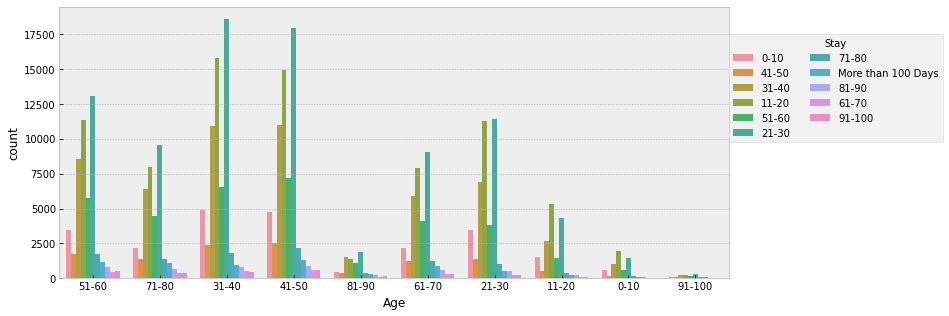

In [45]:
plt.figure(figsize=(12,5))
sns.countplot('Age', data=train, hue='Stay').legend(loc=(1.,0.5), ncol=2, title='Stay');

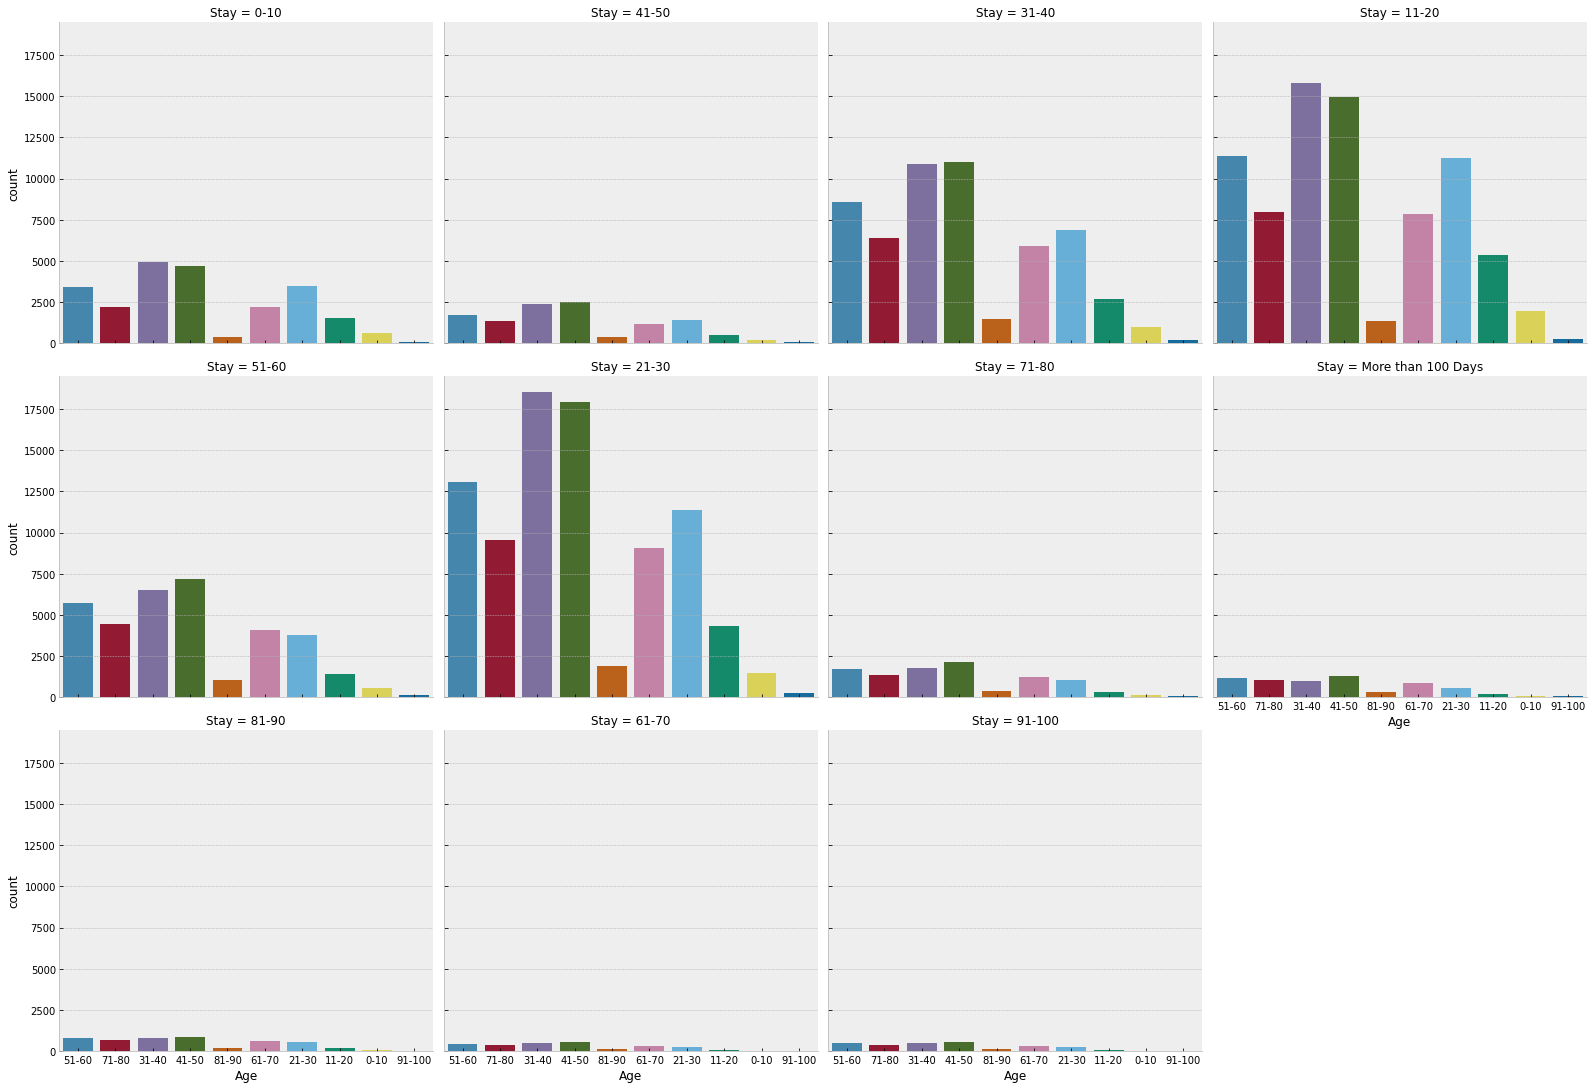

In [68]:
sns.catplot('Age', data=train, col='Stay', col_wrap=4, kind='count', height=5,aspect=1.1);

Most Individuals stay longer than 61 and above days. For all the day categories, patients within 31-40 and 41-50 are the most admitted age groups. We ask ourselves why is it so?

Let's investigate further into the type of admissions and the departments.

In [55]:
train['Type of Admission'].value_counts()

Trauma       152261
Emergency    117676
Urgent        48501
Name: Type of Admission, dtype: int64

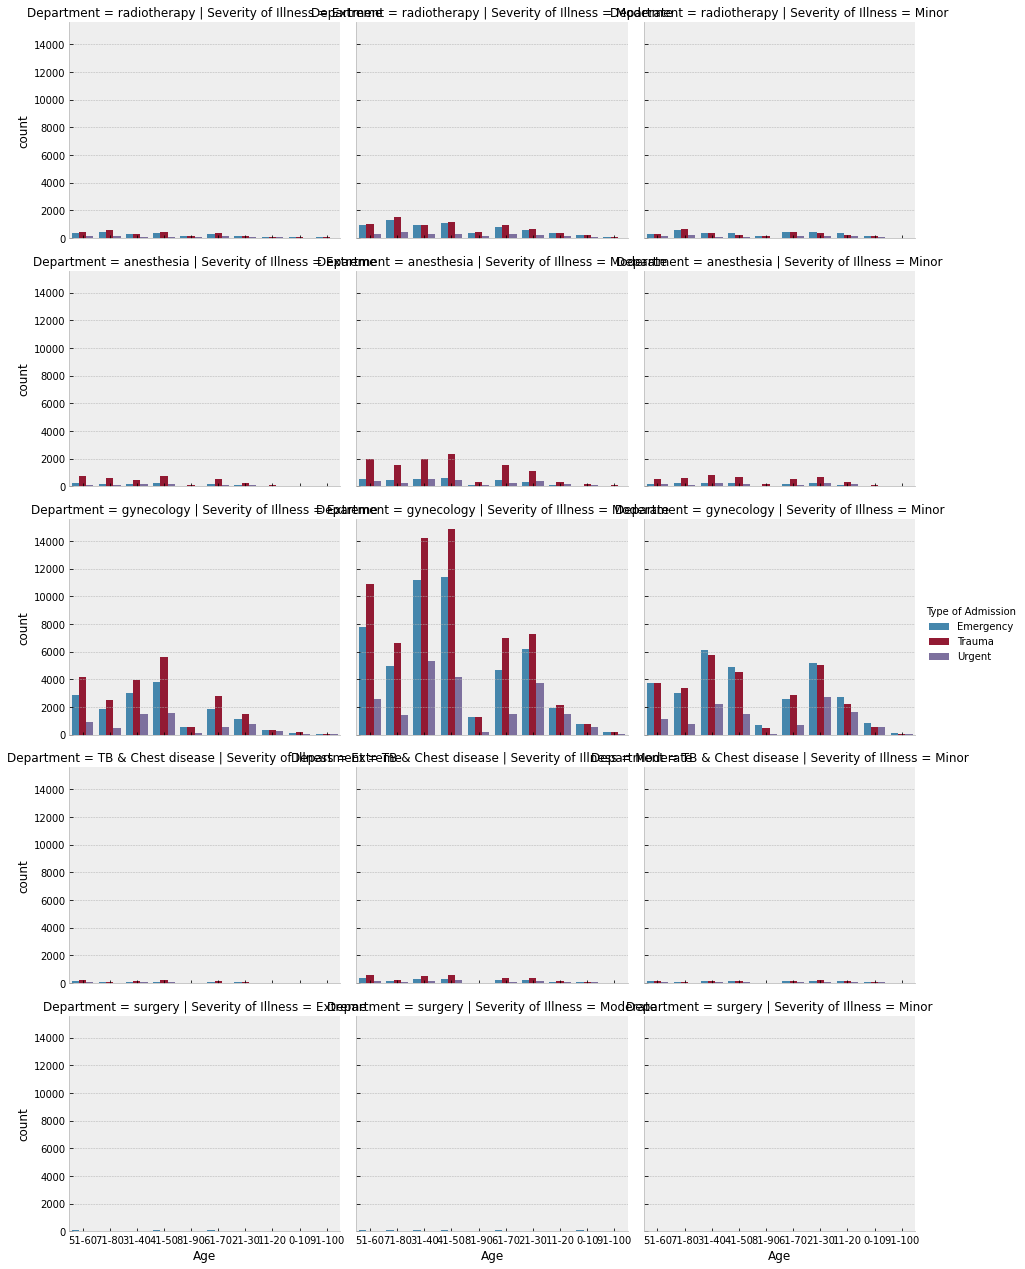

In [85]:
sns.catplot('Age', data=train, hue='Type of Admission', col='Severity of Illness',
            row='Department',kind='count', height=3.5,aspect=1.2);

We see that for all age groups, the department with the most admisions is the Gynaecology department. This indicates that almost all the admissions are composed of female patients of all ages. These admissions are mostly due to emergency and trauma related problems.

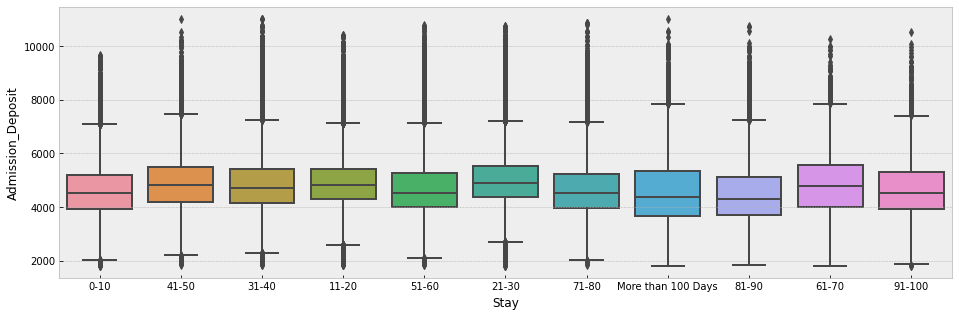

In [91]:
plt.figure(figsize=(16,5))
sns.boxplot('Stay', 'Admission_Deposit', data=train);

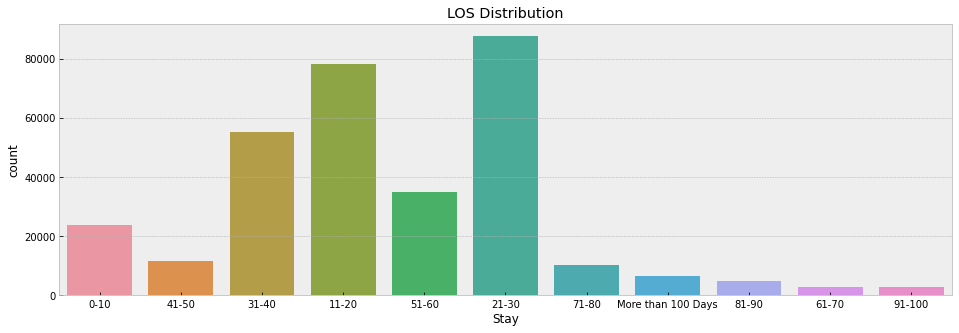

In [100]:
plt.figure(figsize=(16,5))
sns.countplot('Stay', data=train)
plt.title('LOS Distribution');

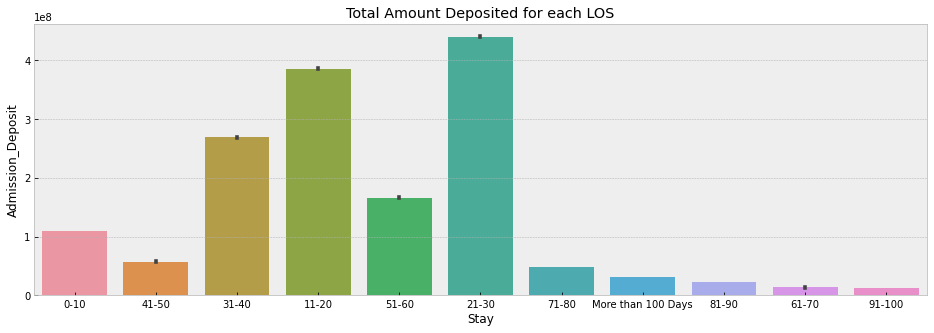

In [101]:
plt.figure(figsize=(16,5))
sns.barplot('Stay', 'Admission_Deposit', data=train, estimator=np.sum)
plt.title('Total Amount Deposited for each LOS');

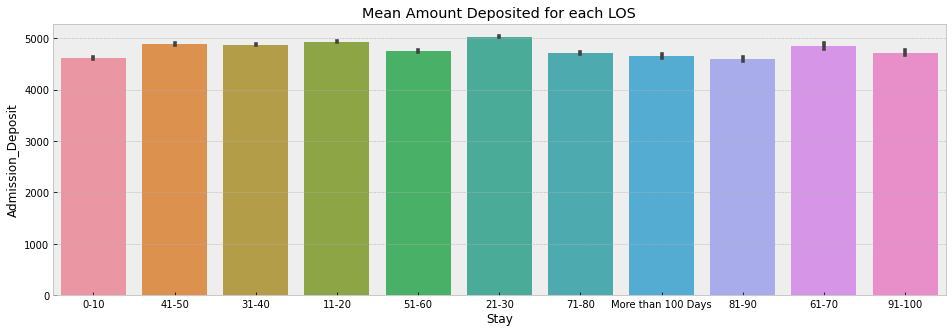

In [102]:
plt.figure(figsize=(16,5))
sns.barplot('Stay', 'Admission_Deposit', data=train)
plt.title('Mean Amount Deposited for each LOS');

In [103]:
train.select_dtypes('object').columns

Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age',
       'Stay'],
      dtype='object')

In [161]:
df = train.append(test)[train.columns]

In [111]:
for col in train.select_dtypes('object').columns:
    print(df[col].unique())

['c' 'e' 'b' 'a' 'f' 'd' 'g']
['Z' 'X' 'Y']
['radiotherapy' 'anesthesia' 'gynecology' 'TB & Chest disease' 'surgery']
['R' 'S' 'Q' 'P' 'T' 'U']
['F' 'E' 'D' 'B' 'A' 'C']
['Emergency' 'Trauma' 'Urgent']
['Extreme' 'Moderate' 'Minor']
['51-60' '71-80' '31-40' '41-50' '81-90' '61-70' '21-30' '11-20' '0-10'
 '91-100']
['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100' nan]


In [131]:
np.sort(train.Age.unique())

array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100'], dtype=object)

In [299]:
stay_map = {'0-10' : 0, '11-20' : 1, '21-30': 2,'31-40': 3, '41-50': 4, '51-60':5, '61-70':6, 
            '71-80' : 7, '81-90' : 8, '91-100' : 9, 'More than 100 Days' : 10}

reverse_stayMap = {b:a for a,b in stay_map.items()}

In [133]:
agemap = {'0-10' : 0, '11-20' : 1, '21-30': 2,'31-40': 3, '41-50': 4, 
          '51-60':5, '61-70':6, '71-80' : 7, '81-90' : 8, '91-100' : 9}

#### Categorical Encoding

In [163]:
df.Age = df.Age.map(agemap)
df.Stay = df.Stay.map(stay_map)

In [164]:
for col in df.select_dtypes('object').columns:
    df[col] = df[col].factorize(sort=True)[0]

In [167]:
train = df[df.Stay.notnull()]
test = df[df.Stay.isnull()].drop('Stay', axis=1)

#### Filling Missing values

In [168]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [178]:
cat_cols

['Hospital_code',
 'Hospital_type_code',
 'City_Code_Hospital',
 'Hospital_region_code',
 'Department',
 'Ward_Type',
 'Ward_Facility_Code',
 'Bed Grade',
 'patientid',
 'City_Code_Patient',
 'Type of Admission',
 'Severity of Illness',
 'Age']

#### Modelling

In [205]:
seed = 42

In [186]:
dummify = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Department',
           'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness']

In [188]:
def linearData():
    train_lin = pd.get_dummies(train, columns=dummify, drop_first=True)
    test_lin = pd.get_dummies(test, columns=dummify, drop_first=True)
    return train_lin, test_lin

In [191]:
def TrainTestData(train, test): 
    X = train.drop(['case_id', 'Stay'], axis=1)
    test_c = test.drop('case_id', axis=1)
    return X, test_c

In [192]:
def data_split(X,y):
    xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=seed, 
                                                  test_size=0.3, stratify=y)
    return xtrain, xval, ytrain, yval

In [196]:
train_lin, test_lin = linearData()

In [202]:
X_lin, test_c_lin = TrainTestData(train_lin, test_lin)
X, test_c = TrainTestData(train, test)
y = train.Stay.astype(int)

In [206]:
xtrain_lin, xval_lin, ytrain, yval = data_split(X_lin, y)
xtrain, xval, ytrain, yval = data_split(X, y)

In [212]:
xtrain.shape, xtrain_lin.shape, xval.shape, xval_lin.shape

((222906, 16), (222906, 113), (95532, 16), (95532, 113))

In [222]:
transform = num_cols+['patientid']

In [225]:
transform

['Available Extra Rooms in Hospital',
 'Visitors with Patient',
 'Admission_Deposit',
 'patientid']

In [226]:
scaler= StandardScaler()
col_transformer = ColumnTransformer(transformers=[('transform', scaler, transform)], 
                                    remainder='passthrough', n_jobs=-1)

In [227]:


catm = cat.CatBoostClassifier(random_seed=seed, early_stopping_rounds=250, silent=True, n_estimators=1000,
                              learning_rate=0.07, eval_metric='MultiClass')

lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=1000, learning_rate=0.04,
                         subsample=0.8, colsample_bytree=0.8, num_leaves=40, metrics='multiclass')

gb = GradientBoostingClassifier(random_state=seed, learning_rate=0.08, n_estimators=700, n_iter_no_change=100,
                                subsample=0.8, min_samples_leaf=5, min_samples_split=10,
                                validation_fraction=0.2)

ext = ExtraTreesClassifier(random_state=seed, min_samples_leaf=10, min_samples_split=15, n_jobs=-1, n_estimators=600,
                           max_samples=0.55, criterion='entropy')

In [244]:
logreg = LogisticRegression(random_state=seed, n_jobs=-1, max_iter=500, C=1, )

In [283]:
logreg_pl = Pipeline([('coltrans', col_transformer), ('logreg', logreg)])

#### Training

In [232]:
y.value_counts()

2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Stay, dtype: int64

In [218]:
def plotImportance(model, title=None, ax=None):
    imp = pd.Series(model.feature_importances_, index=xtrain.columns).sort_values()
    imp.plot.barh(title=title)
    if ax:
        imp.plot.barh(ax=ax, title=title)

In [243]:
TrainModel(logreg_pl, xtrain_lin, xval_lin);

Train ACC: 0.40166 Train Logloss : 1.60202
Val ACC: 0.40189 Val Logloss : 1.60716


In [239]:
TrainModel(ext, xtrain, xval);

Train ACC: 0.49489 Train Logloss : 1.39559
Val ACC: 0.41102 Val Logloss : 1.57894


In [240]:
TrainModel(gb, xtrain, xval);

Train ACC: 0.44412 Train Logloss : 1.46088
Val ACC: 0.42083 Val Logloss : 1.52151


In [246]:
TrainModel(lgbm, xtrain, xval);

Train ACC: 0.50074 Train Logloss : 1.29324
Val ACC: 0.42635 Val Logloss : 1.49799


In [248]:
TrainModel(catm, xtrain, xval);

Train ACC: 0.45211 Train Logloss : 1.42802
Val ACC: 0.42475 Val Logloss : 1.50065


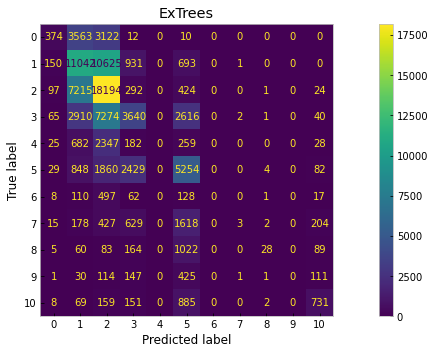

In [264]:
fig, ax= plt.subplots(figsize=(13,5))
figurePlotting(ext, ax, 'ExTrees');

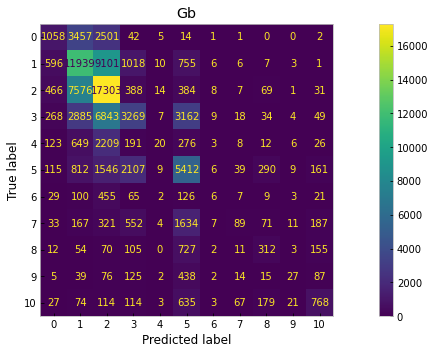

In [265]:
fig, ax= plt.subplots(figsize=(13,5))
figurePlotting(gb, ax,'Gb');

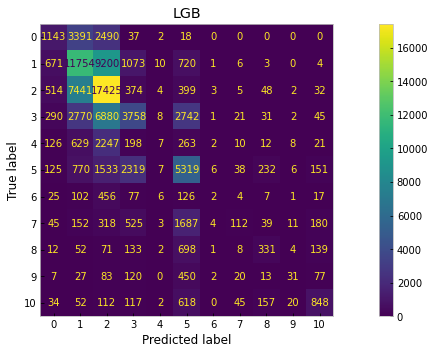

In [266]:
fig, ax= plt.subplots(figsize=(13,5))
figurePlotting(lgbm, ax, 'LGB');

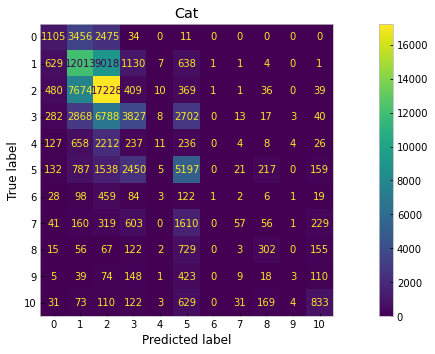

In [267]:
fig, ax= plt.subplots(figsize=(13,5))
figurePlotting(catm, ax, 'Cat')

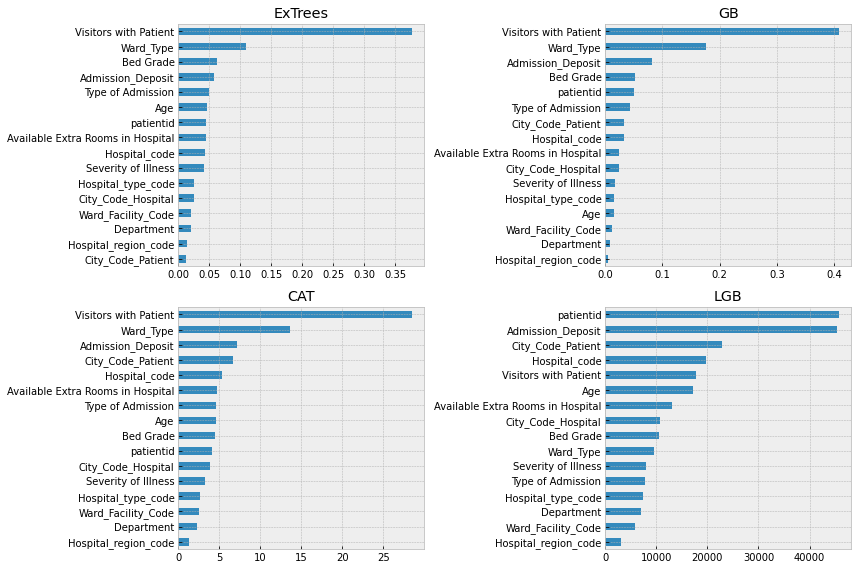

In [269]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
plotImportance(ext, 'ExTrees', ax[0,0])
plotImportance(gb, 'GB', ax[0,1])
plotImportance(catm, 'CAT', ax[1,0])
plotImportance(lgbm, 'LGB', ax[1,1])
plt.tight_layout(pad=1.);

#### Predictions

In [271]:
skfold = StratifiedKFold(shuffle=True, random_state=seed)

In [282]:
scaler.fit_transform(X_lin[transform])

array([[-0.16917678, -0.72792324,  0.02783522, -0.90444157],
       [-1.02521686, -0.72792324,  0.98755589, -0.90444157],
       [-1.02521686, -0.72792324, -0.12491035, -0.90444157],
       ...,
       [-0.16917678, -0.16104865, -0.59418892,  1.56628787],
       [-0.16917678,  0.97270052, -1.03034194,  0.66702219],
       [ 1.5429034 , -0.72792324, -0.11846927, -1.16131444]])

In [279]:
X_lin

,Available Extra Rooms in Hospital,patientid,Visitors with Patient,Age,Admission_Deposit,Hospital_code_2,Hospital_code_3,Hospital_code_4,Hospital_code_5,Hospital_code_6,Hospital_code_7,Hospital_code_8,Hospital_code_9,Hospital_code_10,Hospital_code_11,Hospital_code_12,Hospital_code_13,Hospital_code_14,Hospital_code_15,Hospital_code_16,Hospital_code_17,Hospital_code_18,Hospital_code_19,Hospital_code_20,Hospital_code_21,Hospital_code_22,Hospital_code_23,Hospital_code_24,Hospital_code_25,Hospital_code_26,Hospital_code_27,Hospital_code_28,Hospital_code_29,Hospital_code_30,Hospital_code_31,Hospital_code_32,Hospital_type_code_1,Hospital_type_code_2,Hospital_type_code_3,Hospital_type_code_4,Hospital_type_code_5,Hospital_type_code_6,City_Code_Hospital_2,City_Code_Hospital_3,City_Code_Hospital_4,City_Code_Hospital_5,City_Code_Hospital_6,City_Code_Hospital_7,City_Code_Hospital_9,City_Code_Hospital_10,...,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Ward_Facility_Code_4,Ward_Facility_Code_5,Bed Grade_1.0,Bed Grade_2.0,Bed Grade_3.0,Bed Grade_4.0,City_Code_Patient_1.0,City_Code_Patient_2.0,City_Code_Patient_3.0,City_Code_Patient_4.0,City_Code_Patient_5.0,City_Code_Patient_6.0,City_Code_Patient_7.0,City_Code_Patient_8.0,City_Code_Patient_9.0,City_Code_Patient_10.0,City_Code_Patient_11.0,City_Code_Patient_12.0,City_Code_Patient_13.0,City_Code_Patient_14.0,City_Code_Patient_15.0,City_Code_Patient_16.0,City_Code_Patient_18.0,City_Code_Patient_19.0,City_Code_Patient_20.0,City_Code_Patient_21.0,City_Code_Patient_22.0,City_Code_Patient_23.0,City_Code_Patient_24.0,City_Code_Patient_25.0,City_Code_Patient_26.0,City_Code_Patient_27.0,City_Code_Patient_28.0,City_Code_Patient_29.0,City_Code_Patient_30.0,City_Code_Patient_31.0,City_Code_Patient_32.0,City_Code_Patient_33.0,City_Code_Patient_34.0,City_Code_Patient_35.0,City_Code_Patient_36.0,City_Code_Patient_37.0,City_Code_Patient_38.0,Type of Admission_1,Type of Admission_2,Severity of Illness_1,Severity of Illness_2
0,3,31397,2,5,4911.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31397,2,5,5954.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,31397,2,5,4745.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2,31397,2,5,7272.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2,31397,2,5,5558.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,3,86499,3,4,4144.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
318434,2,325,4,8,6699.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
318435,3,125235,3,7,4235.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [286]:
log_pred = logreg_pl.fit(X_lin, y).predict(test_c_lin)

In [289]:
ext_pred = ext.fit(X,y).predict(test_c)

In [302]:
lgb_pred = lgbm.fit(X,y).predict(test_c)

In [303]:
cat_pred = catm.fit(X,y).predict(test_c)

In [304]:
gb_pred = gb.fit(X,y).predict(test_c)

#### Submissions

In [306]:
log_df = subfile.copy()
log_df['Stay'] = log_pred
log_df.Stay = log_df.Stay.map(reverse_stayMap)

In [309]:
gb_df = subfile.copy()
gb_df['Stay'] = gb_pred
gb_df.Stay = gb_df.Stay.map(reverse_stayMap)

In [310]:
ext_df = subfile.copy()
ext_df['Stay'] = ext_pred
ext_df.Stay = ext_df.Stay.map(reverse_stayMap)

In [311]:
lgb_df = subfile.copy()
lgb_df['Stay'] = lgb_pred
lgb_df.Stay = lgb_df.Stay.map(reverse_stayMap)

In [312]:
cat_df = subfile.copy()
cat_df['Stay'] = cat_pred
cat_df.Stay = cat_df.Stay.map(reverse_stayMap)

In [313]:
log_df.to_csv('predictions/logreg_bl.csv', index=False)
gb_df.to_csv('predictions/gb_bl.csv', index=False)
ext_df.to_csv('predictions/ext_bl.csv', index=False)
lgb_df.to_csv('predictions/lgb_bl.csv', index=False)
cat_df.to_csv('predictions/cat_bl.csv', index=False)

In [316]:
pd.DataFrame(np.c_[log_pred, ext_pred, gb_pred, lgb_pred, cat_pred], 
             columns=['LogReg', 'ExTrees', 'GBM', 'LGB', 'CAT']).corr()

,LogReg,ExTrees,GBM,LGB,CAT
LogReg,1.000000,0.875424,0.870692,0.852080,0.871245
ExTrees,0.875424,1.000000,0.886703,0.882821,0.896775
GBM,0.870692,0.886703,1.000000,0.920281,0.935949
LGB,0.852080,0.882821,0.920281,1.000000,0.939551
CAT,0.871245,0.896775,0.935949,0.939551,1.000000


In [315]:
pd.DataFrame(np.c_[log_pred, ext_pred, gb_pred, lgb_pred, cat_pred], 
             columns=['LogReg', 'ExTrees', 'GBM', 'LGB', 'CAT'])

,LogReg,ExTrees,GBM,LGB,CAT
0,0,0,0,0,0
1,5,5,5,5,5
2,2,2,2,2,2
3,2,2,2,2,2
4,5,5,5,5,5
...,...,...,...,...,...
137052,1,2,2,2,2
137053,1,1,0,0,0
137054,1,2,1,2,1
137055,1,1,1,1,1


In [317]:
gc.collect()

8358